# Credit Card Fraud Detection

## About

Credit card fraud detection is a real world problem that is plaguing the nations. It is an anomaly detection problem due to the Poisson distributed positive cases. Fraud doesn't happen every day, but when it does happen, we want to capture it and predict, given the types of patterns that we can detect, which accounts will likely experience an instance of fraudulent activity.

Being able to work with fraud detection gives us insight into working with all sorts of anomaly detection type problems in the feature, even outside this particular domain.

## The Dataset

The dataset was retrieved from data world, which retrieved it from a Kaggle competitition. It's a flat datset and not necessarily considered big data, however, it will serve its purpose here. 

The attributes for the dataset, for the most part, were stripped so we don't really have a human readable understanding of what the attributes mean, but from what I can tell, the values for each of these anonymized attributes are normalized values.

Our target is a boolean, indicating whether or not the account has experienced fraudulent activity or not.


## Download External Dependencies

In [0]:
!pip install pyod -qq
!pip install imbalance-learn -qq
!pip install keras -qq
!pip install --upgrade tensorflow -qq

     |████████████████████████████████| 92kB 4.4MB/s 
ERROR: Could not find a version that satisfies the requirement imbalance-learn (from versions: none)
ERROR: No matching distribution found for imbalance-learn
     |████████████████████████████████| 86.3MB 126kB/s 
     |████████████████████████████████| 3.8MB 43.9MB/s 
     |████████████████████████████████| 450kB 51.1MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.


## Load Dependencies

In [0]:
# Accessory modules
from collections import Counter
from inspect import signature
import pandas as pd
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
from google.colab import drive
import pandas_profiling
from timeit import default_timer
import warnings
warnings.filterwarnings("ignore")
import tempfile

# Scikit-learn Modules
from sklearn.metrics import (precision_score, confusion_matrix, recall_score, accuracy_score, 
                             balanced_accuracy_score,roc_auc_score, classification_report, confusion_matrix, 
                             r2_score, f1_score, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# PyOD modules
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM

# Keras Modules
from tensorflow import keras
from tensorflow.keras.metrics import (TruePositives, FalsePositives, TrueNegatives, 
                                      FalseNegatives, BinaryAccuracy, Precision, Recall, AUC)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Input, Conv2D, MaxPooling2D, UpSampling2D, 
                          BatchNormalization, Dropout)
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import Constant
from tensorflow import data

# Plotting modules
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Constants

In [0]:
DRIVENAME = "/content/drive/"
# FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/scaled_and_processed_cc.csv"
FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/cc.csv"
FILEURL = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

## Functions

In [0]:
def mount_drive(drivename):
    from google.colab import drive
    drive.mount(drivename)


def load_csv_file(path):
    dataframe = pd.read_csv(FILENAME)
    if isinstance(dataframe["Unnamed: 0"], pd.Series):
        dataframe = dataframe.drop('Unnamed: 0', inplace=False, axis=1)
    return dataframe


def drop_features(dataframe, cols):
    for col in cols:
        dataframe.drop(col, axis=1, inplace=True)
    return dataframe


def rename_target(dataframe, label):
    return dataframe.rename({label: "target"}, axis=1, inplace=False)


def remap_boolean(dataframe, label):
    return dataframe[label].replace({False:0, True:1}, inplace=False)


def scale_feature(dataframe, label):
    eps = 0.001
    # if you want to standardize it use the code that is commented out
    # dataframe[label].apply(lambda x: (x-dataframe[label].mean())/dataframe[label].std())
    return dataframe[label].apply(lambda x: np.log(x.pop(label)+eps))


def preprocess(dataframe, cols_to_drop, cols_to_remap, cols_scale):
    start_time = default_timer()
    dataframe = drop_features(dataframe, cols_to_drop)
    dataframe = rename_target(dataframe, "class")
    dataframe[cols_to_remap] = remap_boolean(dataframe, cols_to_remap)
    dataframe[cols_scale] = scale_feature(dataframe, cols_scale)
    end_time = default_timer()
    print(f"Processing completed. Elapsed time: {end_time-start_time}")
    return dataframe

def split_dataset(df):
    # Use a utility from sklearn to split and shuffle our dataset.
    seed = 42
    test_size=0.3
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=seed)
    train_df, val_df = train_test_split(train_df, test_size=test_size, random_state=seed)

    # Form np arrays of labels and features.
    y_train = np.array(train_df.pop('Class'))
    bool_y_train = y_train != 0
    y_val = np.array(val_df.pop('Class'))
    y_test = np.array(test_df.pop('Class'))

    X_train = np.array(train_df)
    X_val = np.array(val_df)
    X_test = np.array(test_df)
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


def split_data_into_feature_and_target(data, target_label="target"):
    """ Splits the dataframe into features and target
    :param data: is dataframe with last column on right as target
    """
    X = data.loc[:, data.columns != target_label].values
    y = data[target_label].values
    return X, y

def standardize_data(train_features, val_features, test_features):
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    val_features = scaler.transform(val_features)
    test_features = scaler.transform(test_features)

    train_features = np.clip(train_features, -5, 5)
    val_features = np.clip(val_features, -5, 5)
    test_features = np.clip(test_features, -5, 5)

    print('Training features shape:', train_features.shape)
    print('Validation features shape:', val_features.shape)
    print('Test features shape:', test_features.shape)

    return train_features, val_features, test_features



def plot_pca(X, y, list_n_pca_components):
    """ plots a PCA plot... borrowed code that I want to touch as little as possible """
    from sklearn.decomposition import PCA
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import SGDClassifier
    from timeit import default_timer

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                            max_iter=100, tol=1e-5, random_state=0)
    pca = PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
        'pca__n_components': list_n_pca_components,
        'logistic__alpha': np.logspace(-4, 4, 5),
    }

    start_time = default_timer()
    search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
    search.fit(X, y)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    # Plot the PCA spectrum
    pca.fit(X)
    end_time = default_timer()
    print("Elapsed time to fit: {}s".format(end_time - start_time))
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(pca.explained_variance_ratio_, linewidth=2)
    ax0.set_ylabel('PCA explained variance')

    ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
                linestyle=':', label='n_components chosen')
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = 'param_pca__n_components'
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, 'mean_test_score'))

    best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                legend=False, ax=ax1)
    ax1.set_ylabel('Classification accuracy (val)')
    ax1.set_xlabel('n_components')

    plt.tight_layout()
    plt.show()


def extract_pc_into_df(data, n_pca_components):
    from sklearn.linear_model import SGDClassifier
    from sklearn.decomposition import PCA

    X, y = split_data_into_feature_and_target(data)

    logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0, alpha=0.0001)
    
    pca = PCA(n_components=n_pca_components)
    principal_components = pca.fit_transform(X, y)

    princ_comp_names = [f"pc{a}" for a in range(1, 12)]
    dataframe = pd.DataFrame(principal_components, columns=princ_comp_names)
    dataframe['target'] = data['target'].values

    return dataframe


def normality_of_distribution_test(feature, significance_level=0.05):
    from scipy.stats import normaltest
    test_normality = normaltest(feature, axis=0, nan_policy='propagate')
    if test_normality[1]<significance_level:
        print("This feature is normally distributed about the mean")
    else:
        print("This feature is NOT normally distributed about the mean")


def fit_simple_model(data, model_type):
    from timeit import default_timer
    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    if model_type == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        model = GaussianNB()
    else:
        raise ValueError("Please select a valid model_type value")
    
    start_time = default_timer()
    fitted_model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Model fitting and prediction complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time


def make_model(train_features, metrics = METRICS, output_bias=None):
    """ simple neural network model to classify anomalous vs nominal cases """
    if output_bias is not None:
        output_bias = Constant(output_bias)
    
    model = Sequential([
        Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        Dropout(0.5),
        Dense(1, activation='sigmoid',bias_initializer=output_bias),
    ])

    model.compile(
        optimizer=Adam(lr=1e-3),
        loss=BinaryCrossentropy(),
        metrics=metrics)

    return model


def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall', "fn"]
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[1], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  fig, ax = plt.subplots(figsize=(15,15))
  sns.heatmap(cm, annot=True, fmt="d", ax=ax)
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


def plot_roc_curve(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')


def fit_get_predictions_with_CV(data, model_name, param_search_space):
    """ Uses the GridSearchCV to fit specified model. 
    param_search_space must be compatible with models passed in """
    from timeit import default_timer

    X, y = split_data_into_feature_and_target(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    if model_name == "RFC":
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier()
    
    elif model_name == "logistic regression":
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression(class_weight="balanced", verbose=0, random_state=42, 
                                       max_iter=100, solver="saga", warm_start=False, n_jobs=-1, 
                                       l1_ratio=1)
        
    elif model_name == "naive bayes":
        from sklearn.naive_bayes import GaussianNB
        estimator = GaussianNB()

    elif model_name == "KNN":
        from sklearn.neighbors import KNeighborsClassifier
        estimator = KNeighborsClassifier()
    
    else:
        raise ValueError("Please enter a valid model_name string value")

    start_time = default_timer()
    gscv = GridSearchCV(estimator, param_search_space, cv=10, error_score="raise")
    fitted_model = gscv.fit(X_train, y_train)
    y_pred = gscv.predict(X_test)
    end_time = default_timer()
    elapsed_time = end_time - start_time
    print(f"Training, Validation and Testing are complete.\nElapsed Time: {elapsed_time}s")
    return (X_train, X_test, y_train, y_test, y_pred), fitted_model, elapsed_time



def fit_predict_score_outlier_detection_models(model_type, X_train, X_test, y_train, y_test):
    """ fits a specified model within the allowable options """

    supervised = True
    if model_type == "iforest":
        from pyod.models.iforest import IForest
        model = IForest(contamination=0.1, n_estimators=100, max_samples='auto', 
                        max_features=1.0, bootstrap=False, n_jobs=1, behaviour='old', 
                        random_state=42, verbose=0)

    elif model_type == "knn":
        from pyod.models.knn import KNN
        model = KNN(contamination=0.1, n_neighbors=5, method='largest', radius=1.0, 
                    algorithm='auto', leaf_size=30, metric='minkowski', 
                    p=2, metric_params=None, n_jobs=1)
    
    elif model_type == "ocsvm":
        """ can be supervised or unsupervised """
        from pyod.models.ocsvm import OCSVM
        model = OCSVM(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, nu=0.5,
                      shrinking=True, cache_size=200, verbose=False, max_iter=-1, 
                      contamination=0.1)

    elif model_type == "lof":
        """ unsupervised method """
        from pyod.models.lof import LOF
        model = LOF()

    else:
        raise ValueError("Please pass in an accepted model.")
    
    if supervised:
        model.fit(X=X_train, y=y_train)
        test_anomaly_scores = model.decision_function(X_test)
        training_anomaly_scores = model.decision_scores_
        y_pred = model.fit_predict(X_test)
        y_pred_probs = model.predict_proba(X_test)

    else:
        model.fit(X_train)
        generated_train_labels = model.labels_ # 0: inlier; 1: outlier
        training_anomaly_scores = model.decision_scores_
        test_anomaly_scores = model.decision_function(X_train)
        outlier_prediction = model.predict(X_test)

    return (y_pred, y_pred_probs), (training_anomaly_scores, test_anomaly_scores), model



def conf_mat_parser(confusion_matrix):
    """ parse a confusion matrix into its components """""""""""
    TN, FN, FP, TP = [i for j in confusion_matrix for i in j]
    return TN, FN, FP, TP


def detailed_confusion_matrix(y_test, y_pred):
    """ prints out confusion matrix with more labeling and detail """

    TN, FP, FN, TP = conf_mat_parser(confusion_matrix(y_test, y_pred))
    sensitivity = (TP/(TP+FN))
    specificity = (TN/(TN+FP))
    precision = (TP / (TP+FP))

    print("                           *Fraudulent Cases are considered Positive Cases")
    print("============================================================================================")
    print("######################### Predicted Non-Fraudulent ### | ### Predicted Fraudulent ##########")
    print("\n")
    print(f"Actually Non-Fraudulent | TN = {TN}                   | FP = {FP}")
    print("\n")
    print(f"Actually Fraudulent     | FN = {FN}                       | TP = {TP} ")
    print("\n")
    print(f"Specificity: {sensitivity}")
    print(f"Sensitivity (aka. Recall): {specificity}")


def report_performance_scores(model, y_test, y_pred, train_time):
    """ prints out some of the useful performance metrics of our model as well as returns a dataframe containing those metrics """
    from sklearn.metrics import (classification_report, confusion_matrix, 
                                 recall_score, precision_score, roc_auc_score,
                                 accuracy_score, r2_score, f1_score
                                 )
    dataframe = pd.DataFrame({"id":["000"], 
        "best_parameters":f"{model.get_params}", 
        "accuracy":[accuracy_score(y_test, y_pred)], 
        "precision":[precision_score(y_test, y_pred)], 
        "recall":[recall_score(y_test, y_pred)], 
        "roc_auc":[roc_auc_score(y_test, y_pred)], 
        "r2_score":[r2_score(y_test, y_pred)],
        "f1-score": [f1_score(y_test, y_pred)],
        "train_time(s)":f"{train_time}"
        })
    
    pp.pprint(classification_report(y_test, y_pred))
    print("\n")
    print(f"ROC Score: {roc_auc_score(y_test, y_pred)}")
    print("\n")
    detailed_confusion_matrix(y_test, y_pred)
    return dataframe


def perform_mannwhitneyutest(training_anomaly_scores, test_anomaly_scores, significance_level=0.05):
    """ non-parametric version of the t-test for checking if the means betwen two different populations are significantly different """
    from scipy.stats import mannwhitneyu 
    result = mannwhitneyu(test_anomaly_scores, training_anomaly_scores)
    if result[1] < significance_level:
        print("We reject the null hypothesis and conclude that the mean measurements between the two groups are statistically significantly different.")
    else:
        print("We fail reject the null hypothesis and conclude that the mean measurements between the two groups are statistically NOT significantly different.")


def get_max_probas(y_pred_probs):
    """ get array of target probabilities and return an array of 
    prediicted max probabilities for a binary class problem """
    df = pd.DataFrame(y_pred_probs)
    df['max'] = df.max(axis=1)
    y_pred_probs_max = df['max'].values
    return y_pred_probs_max


def predict_max_prob(model, X_test):
    y_pred_probs = model.predict_proba(X_test)
    y_pred_probs_max = get_max_probas(y_pred_probs)
    return y_pred_probs_max


def plot_roc(y_test, y_pred_probs, n_classes=2):
    """ make sure that y_pred are probabilities """
    from sklearn.metrics import roc_curve, auc


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    fig, ax = plt.subplots(figsize=(10, 10))
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operator Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


def plot_prc(y_test, y_pred_probs, y_pred):
    
    average_precision = average_precision_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                if 'step' in signature(plt.fill_between).parameters
                else {})
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.step(recall, precision, color='b', alpha=0.2,
            where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
            average_precision))


def plot_anomaly_score_dists(train_anomaly_scores, test_anomaly_scores):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    plt.suptitle("Distribution of Anomaly Scores for Training and Testing Sets", fontsize=20)

    sns.distplot(test_anomaly_scores, ax=ax1)
    ax1.set_xlabel("Training Anomaly Scores")
    ax1.set_xlim(min(train_anomaly_scores), train_anomaly_scores.std()*10)

    sns.distplot(test_anomaly_scores, ax=ax2)
    ax2.set_xlabel("Test Anomaly Scores")
    ax2.set_xlim(min(test_anomaly_scores), test_anomaly_scores.std()*10)

    plt.show()



def sample_for_test_set(dataframe, target="target", fraction=0.3, include_minority=True):
    """ resample dataframe """
    if include_minority:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.sample(frac=0.3, replace=False), columns=dataframe.columns).reset_index()                         
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    else:
        test_samples_all_nonfraud_df = pd.DataFrame(dataframe.loc[dataframe[target] == 0, :].sample(frac=0.3, replace=False), 
                                                columns=dataframe.columns).reset_index()
        X_test = test_samples_all_nonfraud_df.iloc[:, 1:-1].values # if "index" is the first column
        y_test = test_samples_all_nonfraud_df.loc[:, target].values

    return X_test, y_test


def appropriate_df_sampler(dataframe, target='target'):
    """ heuristic type sampling with first selecting out the nominal vs the anomalous cases """
    fraudulent_data = dataframe.loc[dataframe[target] == 1, :]
    nominal_data = dataframe.loc[dataframe[target] == 0, :]

    training_set = (nominal_data.sample(frac=0.8, random_state=42)
                    .append(fraudulent_data.sample(frac=0.2, random_state=42))).reset_index()

    validation_set = (nominal_data.sample(frac=0.2, random_state=59)
                    .append(fraudulent_data.sample(frac=0.2, random_state=59))).reset_index()

    test_set = fraudulent_data.sample(frac=0.2, random_state=123).reset_index()

    X_train, y_train = training_set.iloc[:, :-1].values, training_set.iloc[:, -1].values
    X_val, y_val = validation_set.iloc[:, :-1].values, validation_set.iloc[:, -1].values
    X_test, _test = test_set.iloc[:, :-1].values, test_set.iloc[:, -1].values

    return (X_train, y_train), (X_val, y_val), (X_test, _test)
    

## Load Dataset

In [0]:
mount_drive(DRIVENAME)
eps = 0.001
from tensorflow.keras import utils
file = utils
df = pd.read_csv(FILEURL)
df.drop("Time", axis=1, inplace=True)
df['log_amount'] = np.log(df.pop("Amount")+eps)
df.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,log_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


## Dataset Profiling and Preliminary EDA

In [0]:
# report = pandas_profiling.ProfileReport(df)
# report

## Preprocessing

In [0]:
# FILENAME = "/content/drive/My Drive/problem_set_challenges_for_job_postings/cc.csv"
# df = preprocess(dataframe=df, cols_to_drop=["column_a", "time"], cols_to_remap="target", cols_scale="amount" )
# df.to_csv("scaled_and_processed_cc.csv")

## More EDA

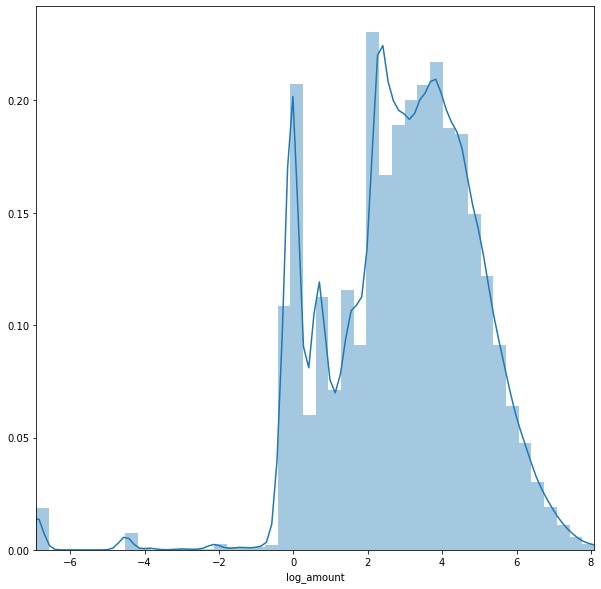

In [0]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df['log_amount'].min(), df['log_amount'].std()*4)
sns.distplot(df['log_amount'])
plt.show()

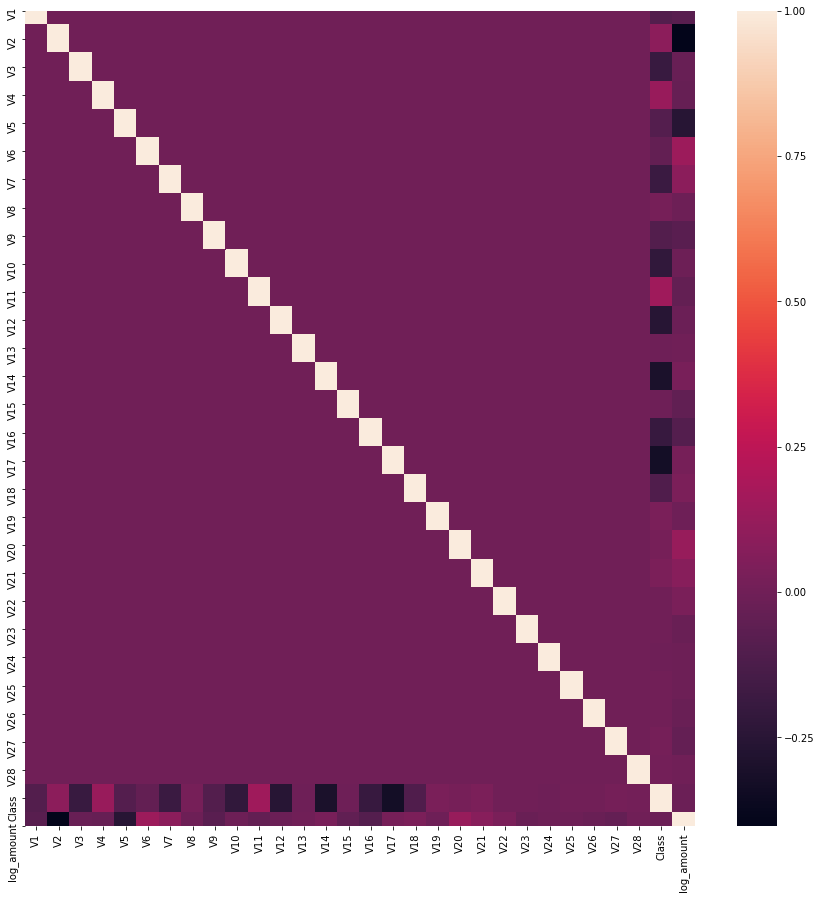

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
corr = df.corr()
sns.heatmap(corr, annot=False)
plt.show()

It's hard to tell what I am looking at from this heatmap, save for the fact that the amount of money withdrawn and the target have a higher degree correlation between the first 10-ish features. 

Feature 2 is significantly negatively correlated to the amount of money draw. We don't have the feature names, but we can probably deduce that Feature 2 might represent a deposit into the account.

Is feature 2 normaly distributed? Lets plot and do statistical checks

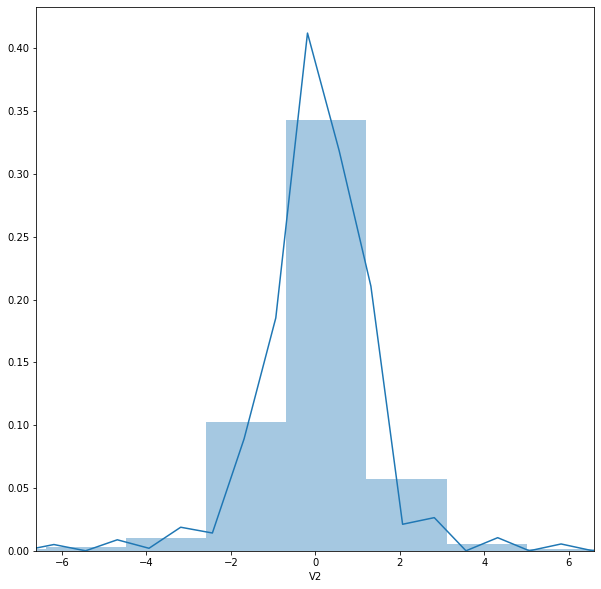

In [0]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim(df.V2.std()*-4, df.V2.std()*4)
sns.distplot(df.V2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04d751c438>,
      dtype=object)

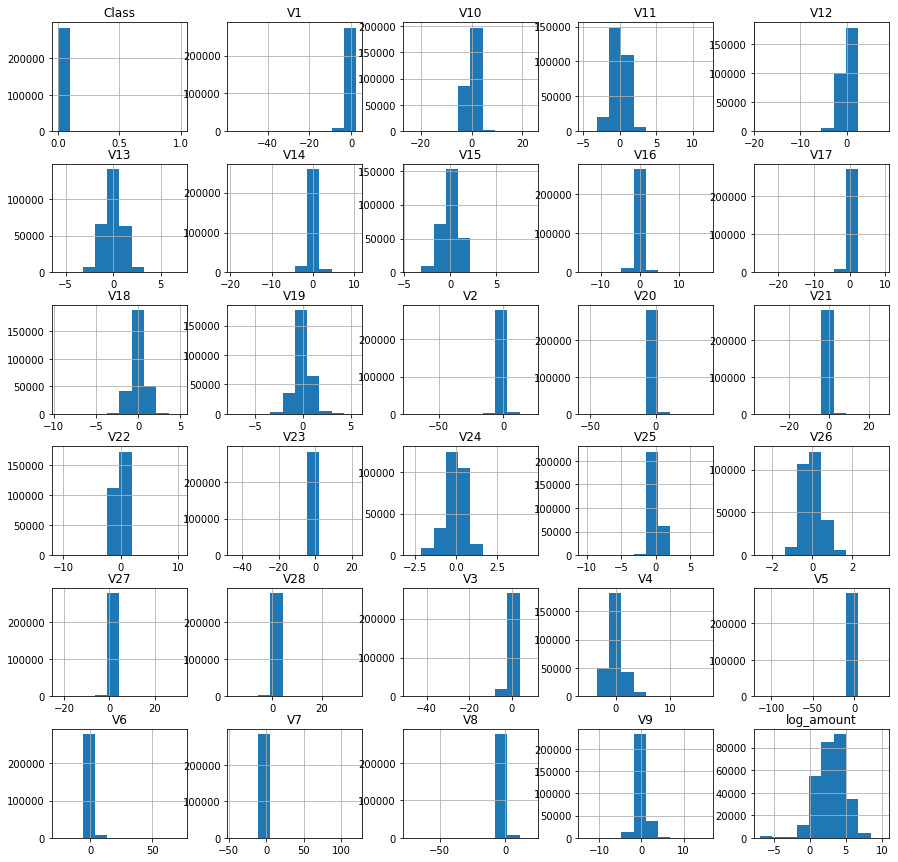

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
df.hist(ax=ax)

### Test for normality of distribution

V2 is a feature of particular interest after what we see from the heatmap. Let's test the normality of its distribution to see what ideas we can have about this particular feature.

In [0]:
normality_of_distribution_test(df.V2)

This feature is normally distributed about the mean


## Split Data into Features and Target

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(df)
bool_train_labels = y_train != 0

In [0]:
X_train, X_val, X_test = standardize_data(X_train, X_val, X_test)

Training features shape: (139554, 29)
Validation features shape: (59810, 29)
Test features shape: (85443, 29)


## Dimensionality Reduction/Feature Extraction with PCA

Best parameter (CV score=0.999):
{'logistic__alpha': 0.0001, 'pca__n_components': 9}
Elapsed time to fit: 60.35021881199998s


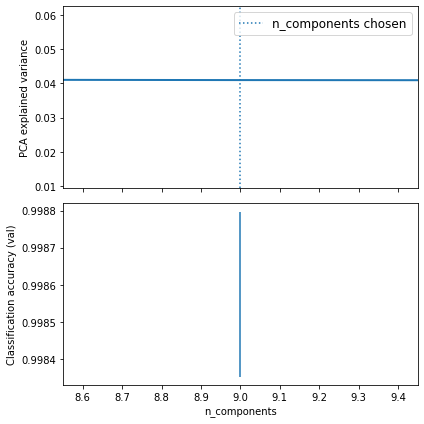

In [0]:
plot_pca(X_train, y_train, [9])

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense?
    * Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.

* Can you see the difference between the ditributions?
    * Yes the positive examples (fraudulent) contain a much higher rate of extreme values.

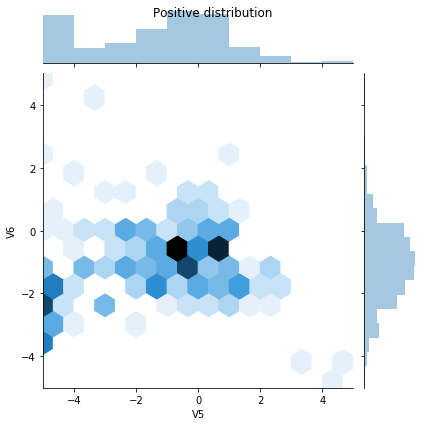

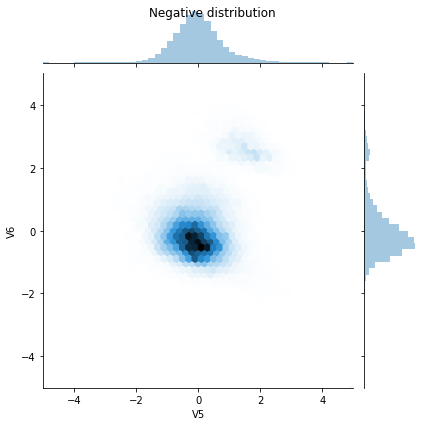

In [0]:
pos_df = pd.DataFrame(X_train[ bool_train_labels], columns = df.columns[df.columns != "Class"])
neg_df = pd.DataFrame(X_train[~bool_train_labels], columns = df.columns[df.columns != "Class"])

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim = (-5,5), ylim = (-5,5))
_ = plt.suptitle("Negative distribution")

Create a version of the dataset using features extracted with PCA

In [0]:
# principalDf = extract_pc_into_df(df, n_pca_components=11)
# principalDf.head()

## Training and Performing Inference with NN

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model(train_features=X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.predict(X_train[:10])

array([[0.21653068],
       [0.49520814],
       [0.4552667 ],
       [0.2780272 ],
       [0.34347802],
       [0.44016248],
       [0.7568342 ],
       [0.3537642 ],
       [0.45300838],
       [0.6732037 ]], dtype=float32)

In [0]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5719


We can initialize better with a informedly chosen bias due to our imbalanced dataset.

Correct bias section can be formed as follows:

* p_0 = pos/(pos + neg) = 1/(1+e^{-b_0})
* b_0 = -log_e(1/p_0 - 1)
* b_0 = log_e(pos/neg)

In [0]:
neg = df['Class'].value_counts()[0]
pos = df['Class'].value_counts()[1]

initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [0]:
# we now predict with this initial calculated bias as opposed to the default np.log(2)
model = make_model(train_features=X_train, output_bias = initial_bias)
model.predict(X_train[:10])

array([[0.00796592],
       [0.00131047],
       [0.01232171],
       [0.00216526],
       [0.0034394 ],
       [0.01466218],
       [0.00417864],
       [0.00274858],
       [0.00297559],
       [0.00972891]], dtype=float32)

In [0]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0116


This initial loss is about 50 times less than if would have been with naive initilization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

Confirm that the careful selection of the training bias is beneficial to the training of the model

In [0]:
model = make_model(train_features=X_train)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

In [0]:
model = make_model(train_features=X_train)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0)

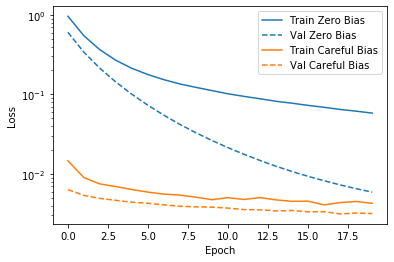

In [0]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

It's clear from this plot that using an informed selected bias is better than using a naive strategy due to the class imbalance in this dataset.

In [0]:
early_stopping=EarlyStopping()

model = make_model(train_features=X_train)
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val))

Train on 139554 samples, validate on 59810 samples
Epoch 1/100
139554/139554 [==============================] - 3s 20us/sample - loss: 0.0139 - tp: 92.0000 - fp: 189.0000 - tn: 139107.0000 - fn: 166.0000 - accuracy: 0.9975 - precision: 0.3274 - recall: 0.3566 - auc: 0.8343 - val_loss: 0.0063 - val_tp: 35.0000 - val_fp: 11.0000 - val_tn: 59701.0000 - val_fn: 63.0000 - val_accuracy: 0.9988 - val_precision: 0.7609 - val_recall: 0.3571 - val_auc: 0.9339
Epoch 2/100
139554/139554 [==============================] - 1s 5us/sample - loss: 0.0090 - tp: 98.0000 - fp: 39.0000 - tn: 139257.0000 - fn: 160.0000 - accuracy: 0.9986 - precision: 0.7153 - recall: 0.3798 - auc: 0.8755 - val_loss: 0.0053 - val_tp: 55.0000 - val_fp: 11.0000 - val_tn: 59701.0000 - val_fn: 43.0000 - val_accuracy: 0.9991 - val_precision: 0.8333 - val_recall: 0.5612 - val_auc: 0.9369
Epoch 3/100
139554/139554 [==============================] - 1s 5us/sample - loss: 0.0078 - tp: 121.0000 - fp: 34.0000 - tn: 139262.0000 - fn: 13

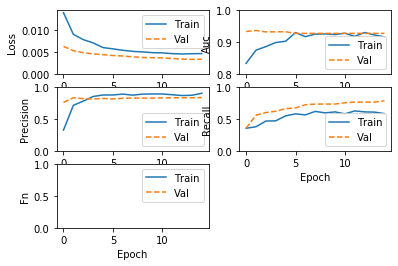

In [0]:
plot_metrics(baseline_history)

In [0]:
train_predictions_baseline = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.00292835691467649
tp :  106.0
fp :  17.0
tn :  85290.0
fn :  30.0
accuracy :  0.9994499
precision :  0.86178863
recall :  0.7794118
auc :  0.9444605

Legitimate Transactions Detected (True Negatives):  85290
Legitimate Transactions Incorrectly Detected (False Positives):  17
Fraudulent Transactions Missed (False Negatives):  30
Fraudulent Transactions Detected (True Positives):  106
Total Fraudulent Transactions:  136


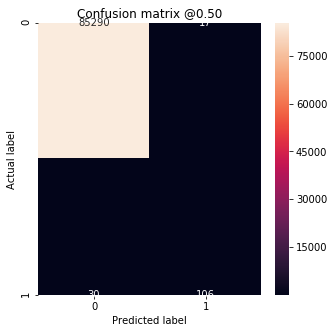

In [0]:
baseline_results = model.evaluate(X_test, y_test,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_baseline)

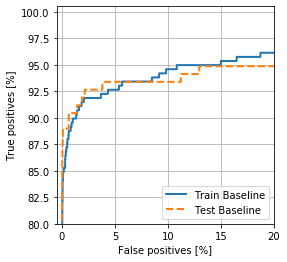

In [0]:
plot_roc_curve("Train Baseline", y_train, train_predictions_baseline, color=colors[0])
plot_roc_curve("Test Baseline", y_test, test_predictions_baseline, color=colors[1], linestyle="--")
plt.legend(loc='lower right')

This is good however, want our model to learn from the positive cases more, due in part by the scarcity of the fraudulent cases. We would then have to pass in the desired scaling for how we want to weight our class predictions in order to adjust for incorrect predictions of the fraudulent class examples.

A good scaling in this case would be to scale total/2 for each case.

In [0]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * ((df.shape[0])/2.0)
weight_for_1 = (1 / pos) * ((df.shape[0])/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


## Re-Training with adjusted class weights

Now we train the model with the adjust class weights to see if there is lift in AUC and Recall for the model.

Note: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like optimizers.SGD, may fail. The optimizer used here, optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [0]:
weighted_model = make_model(train_features=X_train)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    # The class weights go here
    class_weight=class_weight) 

Train on 139554 samples, validate on 59810 samples
Epoch 1/100
139554/139554 [==============================] - 2s 18us/sample - loss: 1.1144 - tp: 128.0000 - fp: 776.0000 - tn: 138520.0000 - fn: 130.0000 - accuracy: 0.9935 - precision: 0.1416 - recall: 0.4961 - auc: 0.8661 - val_loss: 0.4211 - val_tp: 73.0000 - val_fp: 142.0000 - val_tn: 59570.0000 - val_fn: 25.0000 - val_accuracy: 0.9972 - val_precision: 0.3395 - val_recall: 0.7449 - val_auc: 0.9513
Epoch 2/100
139554/139554 [==============================] - 1s 5us/sample - loss: 0.6458 - tp: 172.0000 - fp: 1411.0000 - tn: 137885.0000 - fn: 86.0000 - accuracy: 0.9893 - precision: 0.1087 - recall: 0.6667 - auc: 0.9286 - val_loss: 0.3151 - val_tp: 83.0000 - val_fp: 281.0000 - val_tn: 59431.0000 - val_fn: 15.0000 - val_accuracy: 0.9951 - val_precision: 0.2280 - val_recall: 0.8469 - val_auc: 0.9517
Epoch 3/100
139554/139554 [==============================] - 1s 5us/sample - loss: 0.5420 - tp: 189.0000 - fp: 2140.0000 - tn: 137156.0000 -

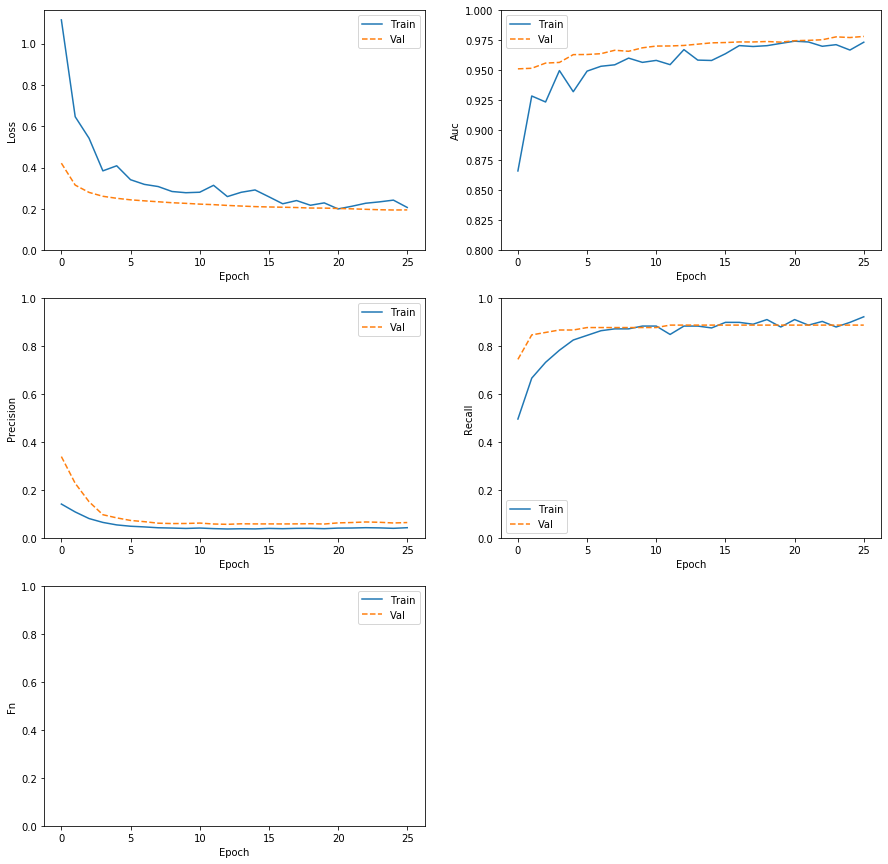

In [0]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_metrics(weighted_history)

In [0]:
train_predictions_weighted = weighted_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.09007471328493964
tp :  124.0
fp :  1774.0
tn :  83533.0
fn :  12.0
accuracy :  0.9790972
precision :  0.06533193
recall :  0.9117647
auc :  0.9804997

Legitimate Transactions Detected (True Negatives):  83533
Legitimate Transactions Incorrectly Detected (False Positives):  1774
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  124
Total Fraudulent Transactions:  136


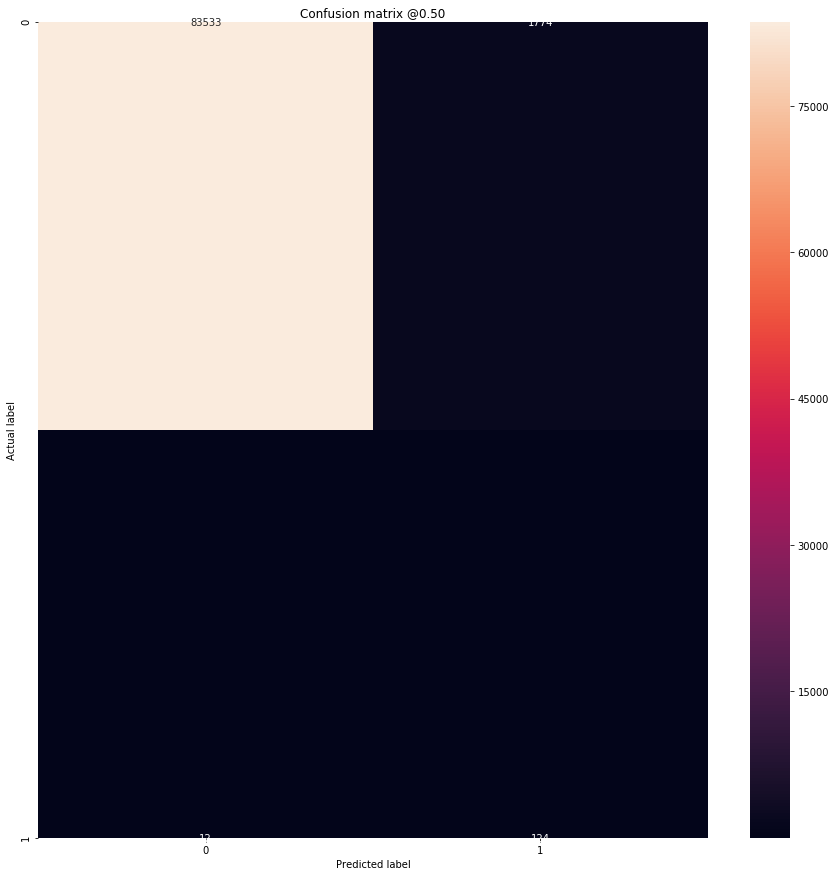

In [0]:
weighted_results = weighted_model.evaluate(X_test, y_test,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_weighted)

## Using Oversampling with Manual sample generation

Resample and append newly selected samples to old samples and shuffle indices.

In [0]:
fraudulent_features = X_train[bool_train_labels]
nominal_features = X_train[~bool_train_labels]

fraudulent_labels = y_train[bool_train_labels]
nominal_labels = y_train[~bool_train_labels]

In [0]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(fraudulent_features, fraudulent_labels)
neg_ds = make_ds(nominal_features, nominal_labels)

Take a look at two examples that were generated and its labels from the positive class

In [0]:
for features, label in pos_ds.take(2):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-4.05303615  3.26724862 -5.          5.         -5.         -1.77259486
 -5.          4.33981849 -5.         -5.          5.         -5.
  0.88964669 -5.          1.09468019 -5.         -5.         -5.
  4.24228468  0.83086824  3.54427218  1.28339961  0.05108858  1.05520695
  0.69531167  0.91618726  2.70852067  0.62140433 -1.24420498]

Label:  1
Features:
 [-0.73511114 -0.48805125  0.74169272  0.27826632 -0.20250226 -0.0401024
  1.05305033  0.16863141 -0.49897823 -0.65623926  1.24566205  0.02771726
 -1.53151454  0.75560892  0.18011748  0.39817171 -0.66572399  0.2542924
 -1.40291242  0.81570039  0.45165621  0.02359624  1.33471809  0.19313272
  0.30160371 -1.28490813 -0.2950715   0.10641004  1.44957744]

Label:  1


In [0]:
resampled_ds = data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [0]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49951171875


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [0]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [0]:
# instead of using the class weights , train the model witht he resampled data instead
resampled_model = make_model(X_train)
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = data.Dataset.from_tensor_slices((X_val, y_val)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)
print(val_ds)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

<PrefetchDataset shapes: ((None, 29), (None,)), types: (tf.float64, tf.int64)>
Train for 278.0 steps, validate for 30 steps
Epoch 1/100
278/278 [==============================] - 10s 36ms/step - loss: 0.3755 - tp: 265272.0000 - fp: 88275.0000 - tn: 196303.0000 - fn: 19494.0000 - accuracy: 0.8107 - precision: 0.7503 - recall: 0.9315 - auc: 0.9424 - val_loss: 0.2323 - val_tp: 87.0000 - val_fp: 1833.0000 - val_tn: 57879.0000 - val_fn: 11.0000 - val_accuracy: 0.9692 - val_precision: 0.0453 - val_recall: 0.8878 - val_auc: 0.9766
Epoch 2/100
278/278 [==============================] - 8s 27ms/step - loss: 0.1911 - tp: 266536.0000 - fp: 19278.0000 - tn: 265230.0000 - fn: 18300.0000 - accuracy: 0.9340 - precision: 0.9326 - recall: 0.9358 - auc: 0.9793 - val_loss: 0.1290 - val_tp: 85.0000 - val_fp: 1280.0000 - val_tn: 58432.0000 - val_fn: 13.0000 - val_accuracy: 0.9784 - val_precision: 0.0623 - val_recall: 0.8673 - val_auc: 0.9780
Epoch 3/100
278/278 [==============================] - 8s 28ms/st

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

Check training history
Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

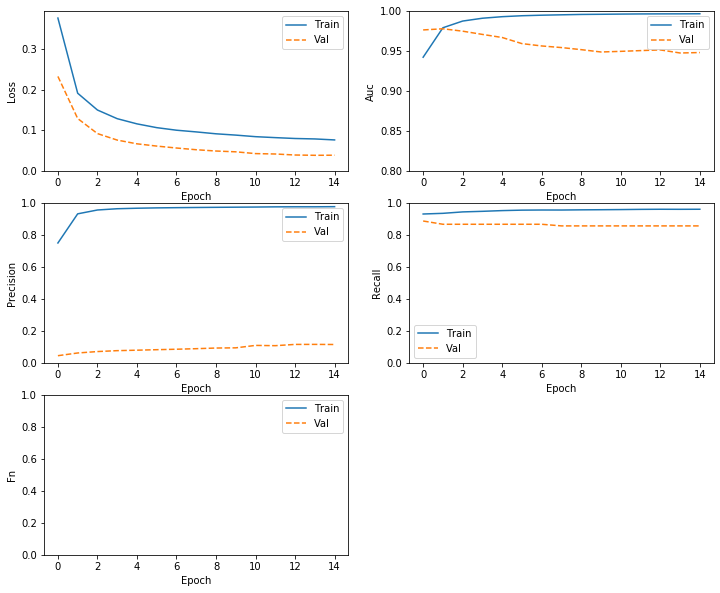

In [0]:
plot_metrics(resampled_history )

Re-train
Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the callbacks.EarlyStopping finer control over when to stop training.

In [0]:
resampled_model = make_model(X_train)
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0]) # seting the vias value of the last layer to 0

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20, # resampled_steps_per_epoch
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

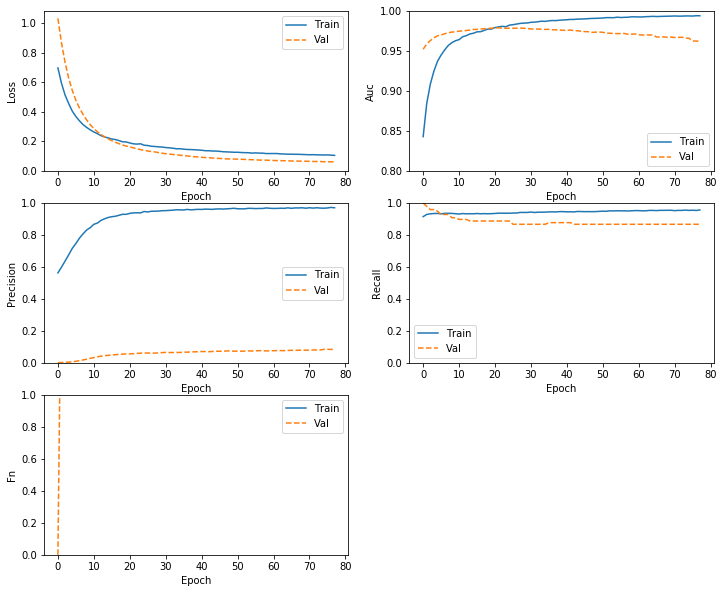

In [0]:
plot_metrics(resampled_history)

Look at the other evaluation metrics using the test set

In [0]:
train_predictions_resampled = resampled_model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(X_test, batch_size=BATCH_SIZE)

loss :  0.06172486593406156
tp :  125.0
fp :  1307.0
tn :  84000.0
fn :  11.0
accuracy :  0.9845745
precision :  0.0872905
recall :  0.9191176
auc :  0.97379535

Legitimate Transactions Detected (True Negatives):  84000
Legitimate Transactions Incorrectly Detected (False Positives):  1307
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  125
Total Fraudulent Transactions:  136


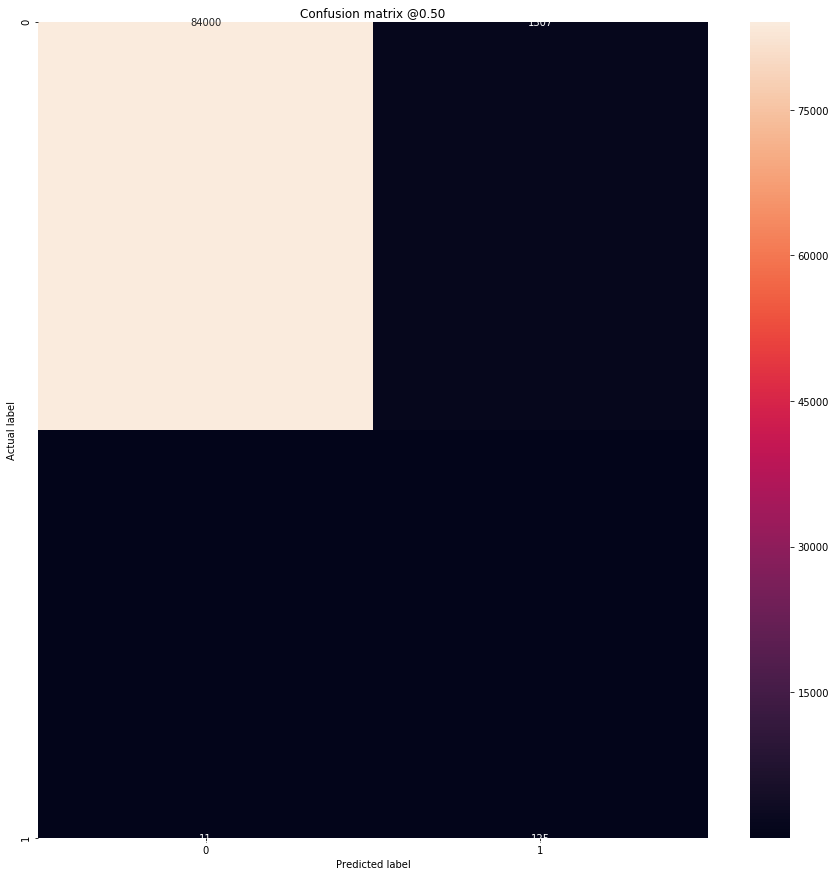

In [0]:
resampled_results = resampled_model.evaluate(X_test, y_test,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions_resampled)

## Novelty Detection with Classic Machine Learning
Given the extremely imbalanced class distribution in the data set, a novelty detection or anomaly detection problem can be framed and appropriate methods can be used in lieu of a classification problem. 

Therefore, the traditional use of the train_test_split module is probably inappropriate in this case and specifically training on 

Train the data on only nominal cases (with one anomalous case, just so the model doesnt break) and then test on anomalous cases to see how well we do in an semi-supervised learning approach

### Using train test split with IFOREST

In [0]:
X, y = split_data_into_feature_and_target(principalDf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

predictions, anomaly_scores, model = fit_predict_score_outlier_detection_models("iforest", X_train, X_train, y_train, y_test)

In [0]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [0]:
print(pd.Series(anomaly_scores[0]).describe())
print(f"med: {np.median(anomaly_scores[0])}")

In [0]:
print(pd.Series(anomaly_scores[1]).describe())
print(f"med: {np.median(anomaly_scores[1])}")

In [0]:
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

In [0]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), model.predict(X_test))

## Conclusion of Train_test_split for Outlier/Anomaly/Novelty Detection with IFOREST

We see that the decision function has not learned from enough fradulent samples due this random sample partitioning method. A more heuristic approach should be pursued when approaching an anomaly detection/novelty detection problem.

## Using alternative data partitioning with IFOREST

In [0]:
training_data = principalDf.loc[principalDf["target"] == 0, :]
training_data = training_data.append(principalDf.iloc[6329, :])
X_train = training_data.iloc[:, :-1].values
y_train = training_data.iloc[:, -1].values

In [0]:
test_data = principalDf.loc[principalDf.target==1, :]
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

In [0]:
predictions, anomaly_scores, model = fit_predict_score_outlier_detection_models("iforest", X_train, X_train, y_train, y_test)

In [0]:
score = model.fit_predict_score(X_train, y_train, scoring='roc_auc_score')
score

In [0]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [0]:
print(pd.Series(anomaly_scores[0]).describe())
print(f"med: {np.median(anomaly_scores[0])}")

Comment: there is a clear flip in the distribution in the distribution of anomaly values produced by the Isolation forest when comparing the fradulent cases vs the nominal cases. 

In [0]:
print(pd.Series(anomaly_scores[1]).describe())
print(f"med: {np.median([1])}")

In [0]:
detailed_confusion_matrix(y_test, model.predict(X_test))

In [0]:
perform_mannwhitneyutest(anomaly_scores[0], anomaly_scores[1])

In [0]:
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

This probably occured because I only included 1 fraudulent case in the training dataset...

In [0]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), model.predict(X_test))

Same as above.

## Alternate sampling strategy with IForest

Another sampling strategy to partition the number  of fraudulent cases I employ is split it as such:

* 60% fraudulent data for training
* 20% fraudulent data for validation
* 20% fraudulent data for testing (test set will comprise only of the fraudulent cases)

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = appropriate_df_sampler(principalDf)

In [0]:
predictions, anomaly_scores, model = fit_predict_score_outlier_detection_models("iforest", X_train, X_val, y_train, y_val)

In [0]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [0]:
perform_mannwhitneyutest(anomaly_scores[0], anomaly_scores[1])

In [0]:
plot_roc(y_val, get_max_probas(predictions[1]))

In [0]:
y_pred = model.predict(X_test)
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

In [0]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), y_pred)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

## Conclusion of Alternate Sampling Strategy

Using Isolation forest with an appropriate method of data partitioning the results in a fantastic precision score , in the case where we perform feature extraction with PCA before hand.

## Alternative Sampling Strategy with IFOREST and original dataset

Repeat the above again except with the original dataset

* 60% fraudulent data for training
* 20% fraudulent data for validation
* 20% fraudulent data for testing (test set will comprise only of the fraudulent cases)

In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = appropriate_df_sampler(df)

In [0]:
predictions, anomaly_scores, model = fit_predict_score_outlier_detection_models("iforest", X_train, X_val, y_train, y_val)

In [0]:
plot_anomaly_score_dists(anomaly_scores[0], anomaly_scores[1])

In [0]:
perform_mannwhitneyutest(anomaly_scores[0], anomaly_scores[1])

In [0]:
plot_roc(y_val, get_max_probas(predictions[1]))

In [0]:
y_pred = model.predict(X_test)
plot_roc(y_test, get_max_probas(model.predict_proba(X_test)))

In [0]:
plot_prc(y_test, get_max_probas(model.predict_proba(X_test)), y_pred)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

### Conclusion of IForest with alterative sampling with original dataset

We get even slightly better precision results when we apply isolation forest to the original dataset, when compared to the pca-reduced dataset.

## Addressing Class Imbalance - Down Sampling Majority Class

Another approach to addressing the problem of class imbalance is with down-sampling the majority class. This is something we've done before in a few other problems, and it might not be an option in all the cases. In this case, however, I think we have enough data points in total, and enough cases of the majority class we can down sample from. 

Keep in mind, we want to downsample to include the most influential and representative samples to learn from from the majority negative class. We will be making use of the SMOTE python library and its methods to select an approprirate down-sampling strategy for our problem

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs_max = get_max_probas(fitted_model.predict_proba(X_test))

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
detailed_confusion_matrix(y_test, y_pred)

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
print(f"{1753/(1753+83541)} %")

There were no fraudulent cases in this step, however, there alarm in the model went off in the cases of 1753 cases, with this type of naive sampling in this instance. This model therefore would cause unncessary harm and arm in its clients 2% of the time, which is too shockingly high of a number. This needs to be lowered because the harm and alarm of false positive cases can be enough for your clients to end their relationship with you.

In [0]:
plot_roc(y_test, y_pred)

## Undersampling of the Majority Class with OneSidedSelection

In the contrary, OneSidedSelection will use TomekLinks to remove noisy samples [KM1997]. In addition, the 1 nearest neighbor rule is applied to all samples and the one which are misclassified will be added to the set C. No iteration on the set S will take place.

In [0]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [0]:
OSS_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(OSS_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

In [0]:
plot_roc(y_test, y_pred)

This method seems like a more balanced approach to undersampling the minority case. We see that we've kept the same number of majority cases somehow, but achieved much better performance with this type of sampling strategy. I've not read in depth about how the sampling strategy employed but I think it will be important to know how it is done. Something about Tomek links.

## Test Modeling against Test dataset (previous majority down sampling)

Create a test data set by resampling a portion of the non-fraud cases and make that the entire test dataset.

In [0]:
# only non-fraudulent cases for this test
X_test, y_test = sample_for_test_set(principalDf, include_minority=False)

In [0]:
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
plot_roc(y_test, y_pred)

In [0]:
# Include minority cases in the sampling
X_test, y_test = sample_for_test_set(principalDf, fraction=0.5, include_minority=True)

In [0]:
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred = fitted_model.predict(X_test)

In [0]:
y_pred = pd.Series(y_pred)
y_pred.value_counts()

In [0]:
report = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report.head()

In [0]:
y_pred = fitted_model.predict(X_test)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
plot_roc(y_test, y_pred_probs_max)

In [0]:
detailed_confusion_matrix(y_test, y_pred)

# Conclusion of Down Sampling Strategy

Using the OneSideSelection down sampling strategy, fitting a model to this dataset, and then testing on a purely majority-class dataset yields positive expected values (i.e., almost 0 fraudulent cases predicted), meaning that the decision function has learned of some of the patterns for fraudulent activity.

Having a higher Sensitivity score here is important because we want to capture as much of the fraudulent activity as possible, while mitigating the number of missed-detections and the number of false-alarms. In this case, there were 30 missed fraudulent cases that went under the radar and 5 false alarms for the 124 pings for frauduldent activity.

This is a start but this is certainly not good enough. We need to get that False-Positive rate/Missed-Fraudulent number as low as possible.

### Over sampling of the Minority Class

We over sample the minority class to have more examples to learn from, but rather than just randomly doing it, there are some technicality to the approaches that we can choose. I'll go through training a decision function with resampling using two powerful methods offered by the imbalanced-learn library:

1) SMOTE - Synthetic Minority Oversampling Technique

2) ADASYN - Adaptive Synthetic sampling

These two oversampling approaches use methods of interpolation to generate synthetic samples as opposed to the type of sampling done with Random over sampling, which duplicates examples.

Formula for SMOTE sample generation:

![Formula for SMOTE sample generation](https://imbalanced-learn.readthedocs.io/en/stable/_images/math/7d17f8d1d74c655eb15821661276d94c82d0e5b4.png)

Lambda is a value between 0 and 1 and a sample is interpolated along the line between Xi and Xzi.

<br>

![Sampling](https://imbalanced-learn.readthedocs.io/en/stable/_images/sphx_glr_plot_illustration_generation_sample_0011.png)



In [0]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

In [0]:
smote_df = pd.DataFrame(np.c_[X_resampled, y_resampled], columns=principalDf.columns)

In [0]:
param_grid = {
    "n_neighbors":[3, 4, 5]
}

knn_data_bundle, fitted_model, elapsed_time = fit_get_predictions_with_CV(smote_df, "KNN", param_grid)

y_pred = knn_data_bundle[4]
y_test = knn_data_bundle[3]

In [0]:
report_df = report_performance_scores(fitted_model, y_test, y_pred, elapsed_time)
report_df.head()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=0.3, random_state=42)
y_pred_probs = fitted_model.predict_proba(X_test)
y_pred_probs_max = get_max_probas(y_pred_probs)

In [0]:
plot_roc(y_test, y_pred_probs_max)